In [1]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.models as models
import torchvision.transforms as T
import torch.nn.functional as F
import seaborn as sns
from tqdm import tqdm
from collections import Counter
from torch import nn, Tensor
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CIFAR100
from typing import Optional, Callable
from torchvision.transforms import v2
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity

# Data loader

In [2]:
class CIFAR100_noisy_fine(Dataset):
    def __init__(
        self, root: str, train: bool, transform: Optional[Callable], download: bool
    ):
        cifar100 = CIFAR100(
            root=root, train=train, transform=transform, download=download
        )
        data, targets = tuple(zip(*cifar100))

        if train:
            noisy_label_file = os.path.join(root, "CIFAR-100-noisy.npz")
            if not os.path.isfile(noisy_label_file):
                raise FileNotFoundError(
                    f"{type(self).__name__} need {noisy_label_file} to be used!"
                )

            noise_file = np.load(noisy_label_file)
            if not np.array_equal(noise_file["clean_label"], targets):
                raise RuntimeError("Clean labels do not match!")
            targets = noise_file["noisy_label"]

        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, i: int):
        return self.data[i], self.targets[i]

In [3]:
# No transformations needed since noise is present just in labels
train_set = CIFAR100_noisy_fine(
    '/kaggle/input/fii-atnn-2025-project-noisy-cifar-100/fii-atnn-2024-project-noisy-cifar-100', 
    download=False, 
    train=True, 
    transform=None)

# Some data visualization

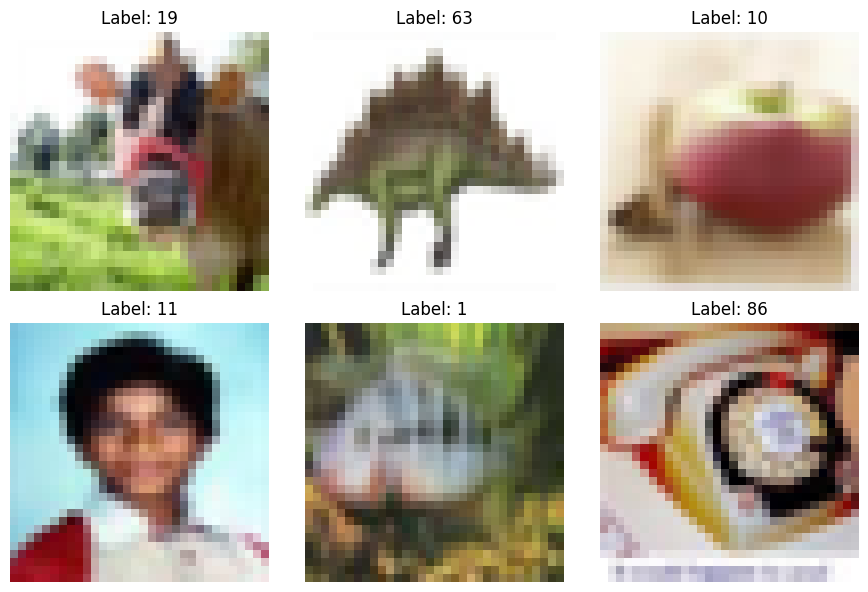

In [4]:
fig, axes = plt.subplots(2, 3, figsize=(9, 6))

for i, ax in enumerate(axes.flatten()):
    img, label = train_set[i]  

    ax.imshow(img)
    ax.set_title(f"Label: {label}")
    ax.axis("off")

plt.tight_layout()
plt.show()

# Label Distribution

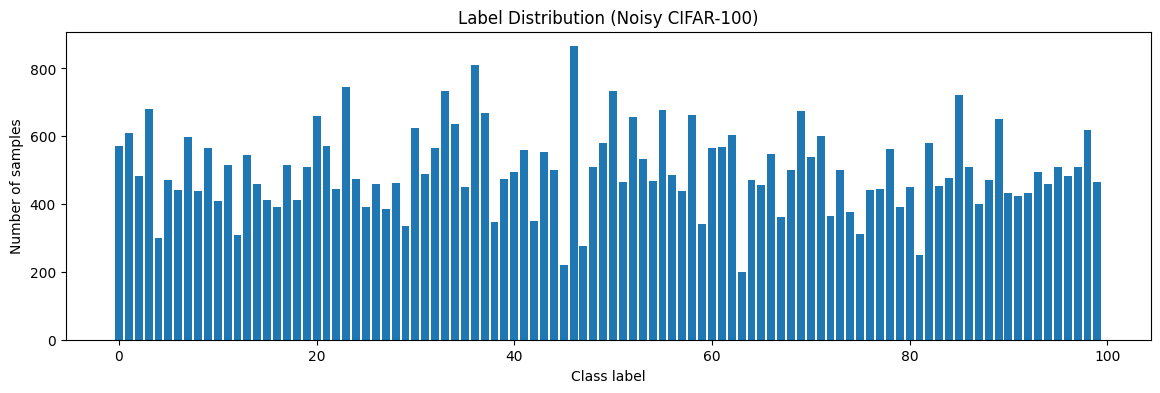

In [5]:
labels = train_set.targets

label_counts = Counter(labels)

labels_sorted = sorted(label_counts.keys())
counts_sorted = [label_counts[l] for l in labels_sorted]

plt.figure(figsize=(14, 4))
plt.bar(labels_sorted, counts_sorted)
plt.xlabel("Class label")
plt.ylabel("Number of samples")
plt.title("Label Distribution (Noisy CIFAR-100)")
plt.show()

Number of classes: 100
Min samples per class: 199
Max samples per class: 865
Mean samples per class: 500.0
Median samples per class: 484.5
Std deviation: 122.7382580942063
25th percentile: 436.75
75th percentile: 569.75
Interquartile Range (IQR): 133.0


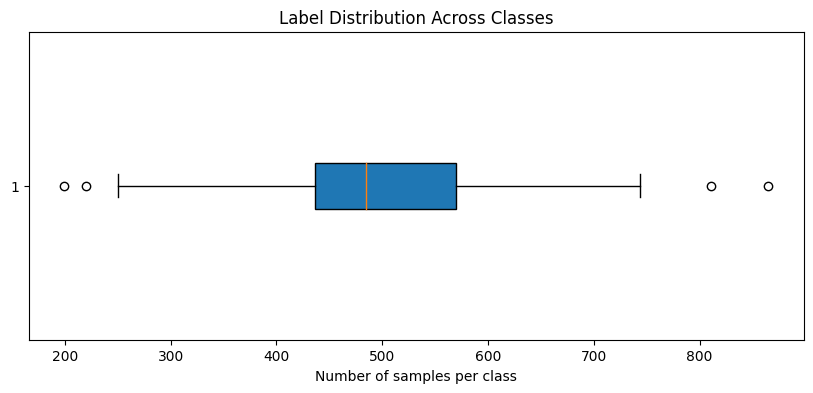

In [6]:
labels = train_set.targets
label_counts = Counter(labels)
labels_sorted = sorted(label_counts.keys())
counts_sorted = [label_counts[l] for l in labels_sorted]

counts = np.array(counts_sorted)

print("Number of classes:", len(counts))
print("Min samples per class:", counts.min())
print("Max samples per class:", counts.max())
print("Mean samples per class:", counts.mean())
print("Median samples per class:", np.median(counts))
print("Std deviation:", counts.std())

q75, q25 = np.percentile(counts, [75 ,25])
iqr = q75 - q25
print("25th percentile:", q25)
print("75th percentile:", q75)
print("Interquartile Range (IQR):", iqr)

plt.figure(figsize=(10, 4))
plt.boxplot(counts, vert=False, patch_artist=True)
plt.title("Label Distribution Across Classes")
plt.xlabel("Number of samples per class")
plt.show()

In [7]:
threshold = counts.mean() * 0.5
rare_classes = [l for l, c in label_counts.items() if c < threshold]

top_threshold = counts.mean() * 1.5
top_classes = [l for l, c in label_counts.items() if c > top_threshold]

print("Number of rare classes:", len(rare_classes))
print("Rare classes:", rare_classes)
print("Number of top classes:", len(top_classes))
print("Top classes:", top_classes)

Number of rare classes: 2
Rare classes: [63, 45]
Number of top classes: 2
Top classes: [36, 46]


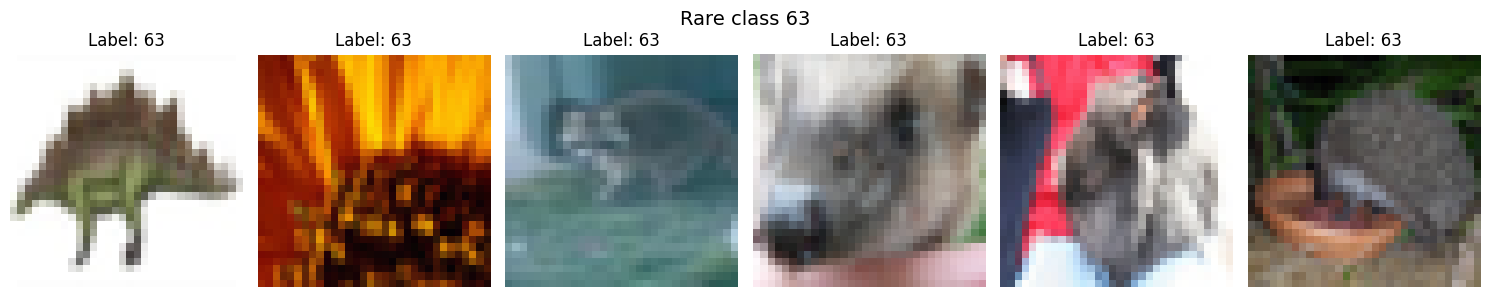

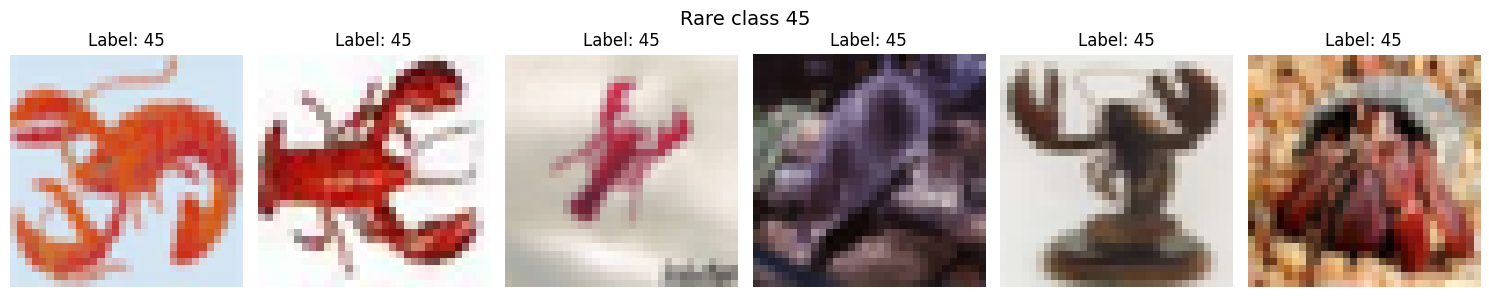

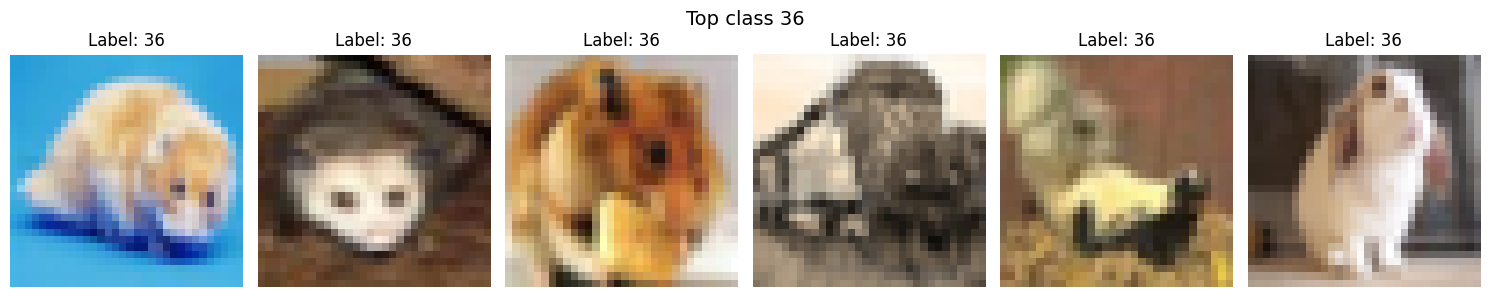

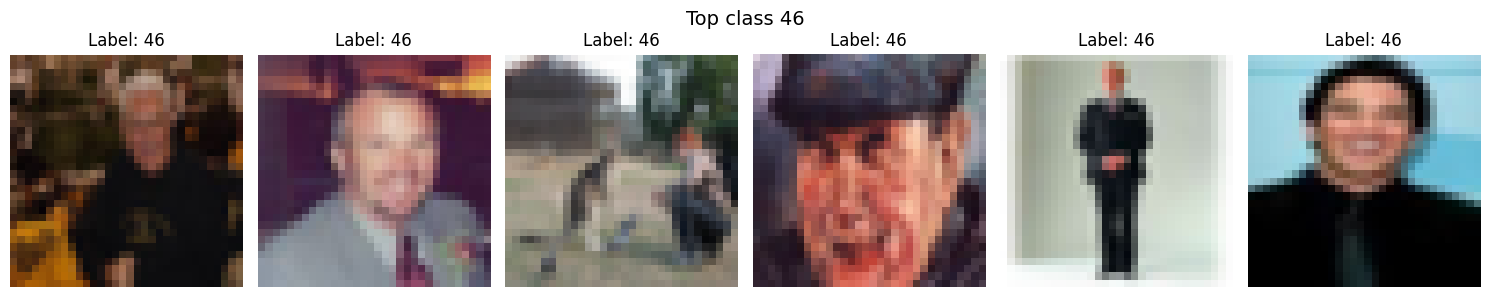

In [8]:
classes_to_show = {
    "Rare class 63": 63,
    "Rare class 45": 45,
    "Top class 36": 36,
    "Top class 46": 46
}

for class_name, class_label in classes_to_show.items():
    indices = [i for i, label in enumerate(train_set.targets) if label == class_label][:6]  

    fig, axes = plt.subplots(1, 6, figsize=(15, 3))
    fig.suptitle(class_name, fontsize=14)

    for ax, idx in zip(axes, indices):
        img, label = train_set[idx]  
        ax.imshow(img)
        ax.set_title(f"Label: {label}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

**Findings**:
- label classes are really unbalanced as you can see from the barplot;
- the unevenes between the classes doesn't really tell us which classes may contain noise, but there are definately some outliers present;
- out of 100 classes, the mean is around 500 samples per class with a standard deviation of around 122;
- class 45 and 63 are the ones we consider rare (their number of samples is below half of the mean);
- class 36 and 46 are the ones we consider top (theit number of samples are way too high, which might be a sign of noisy labels);
- display some images doesn't give a lot of information (analyzing each image is unfeasible and time consuming);
- no assumption based on rarity can be made because class 63 is rare and from the images, it can be seen that they don't represent the same concept;

# Intra-Class Consistency

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
resnet = resnet.to(device)
resnet.eval()

# Remove the final classification layer since we only care about the feature embeddings
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 173MB/s]


In [10]:
embed_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),              
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [11]:
features = []
labels = []

with torch.no_grad():
    for img, label in tqdm(train_set):
        x = embed_transform(img).unsqueeze(0).to(device)  
        feat = resnet(x)                                  
        feat = feat.squeeze().cpu()                       
        features.append(feat)
        labels.append(label)

features = torch.stack(features) 
labels = torch.tensor(labels)

100%|██████████| 50000/50000 [03:13<00:00, 258.08it/s]


In [12]:
num_classes = 100
centroids = torch.zeros((num_classes, features.size(1)))

for c in range(num_classes):
    class_feats = features[labels == c]
    if len(class_feats) > 0:
        centroids[c] = class_feats.mean(dim=0)

In [13]:
distances = torch.zeros(len(features))

for i in range(len(features)):
    label = labels[i]
    distances[i] = torch.norm(features[i] - centroids[label])

## Look over the rare and top classes

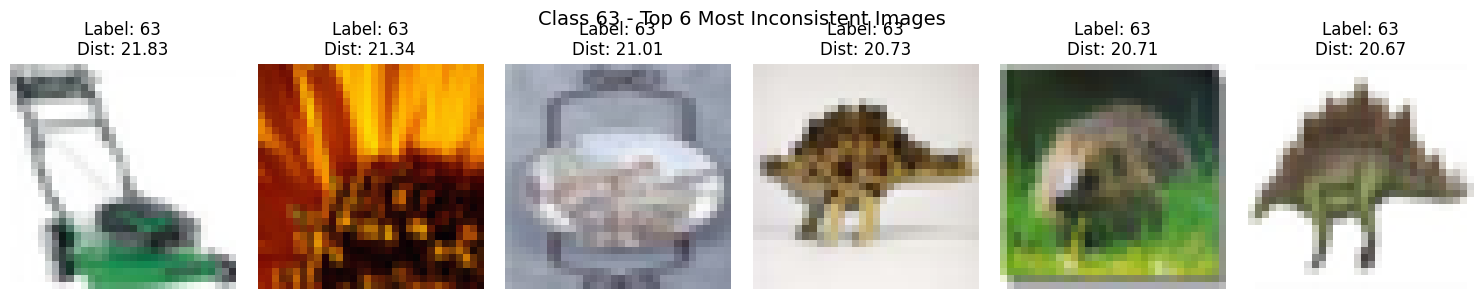

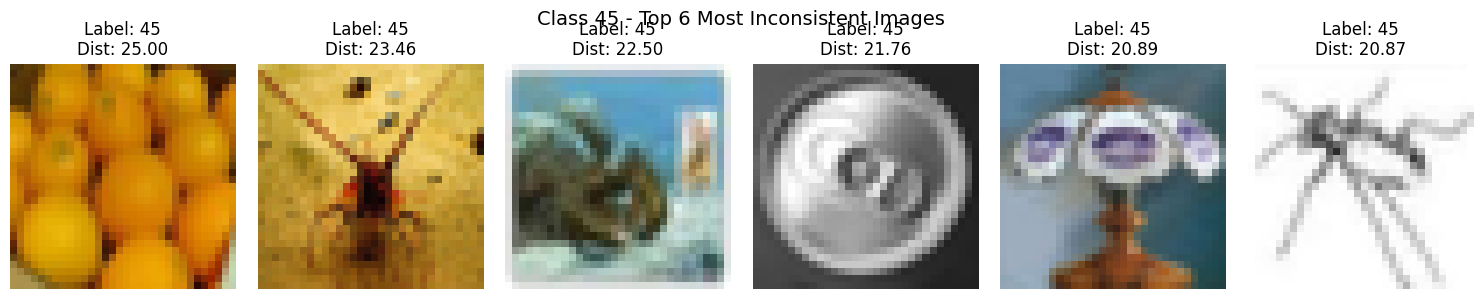

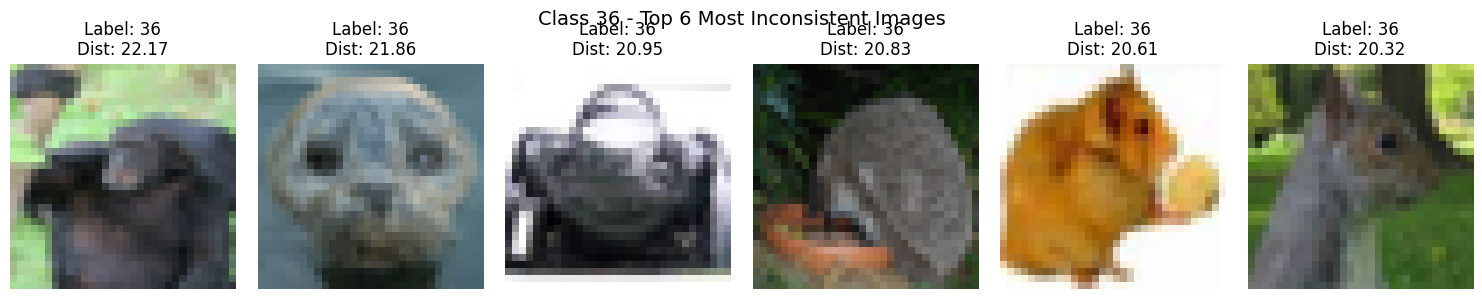

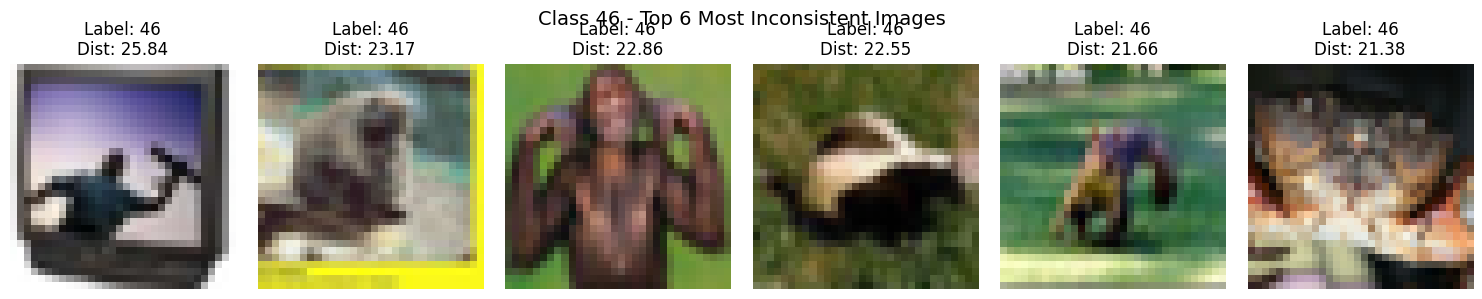

In [14]:
topk = 6

for c in [63, 45, 36, 46]:
    class_indices = (labels == c).nonzero(as_tuple=True)[0]
    class_distances = distances[class_indices]
    top_outliers = class_indices[class_distances.topk(topk).indices]

    fig, axes = plt.subplots(1, topk, figsize=(15, 3))
    fig.suptitle(f"Class {c} - Top {topk} Most Inconsistent Images", fontsize=14)

    for ax, idx in zip(axes, top_outliers):
        img, label = train_set[idx]
        ax.imshow(img)
        ax.set_title(f"Label: {label}\nDist: {distances[idx]:.2f}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

In [15]:
num_classes = 100
class_stats = {}

for c in range(num_classes):
    class_indices = (labels == c).nonzero(as_tuple=True)[0]
    if len(class_indices) == 0:
        continue  
    
    class_distances = distances[class_indices].cpu().numpy()
    
    mean_dist = class_distances.mean()
    std_dist = class_distances.std()
    max_dist = class_distances.max()
    median_dist = np.median(class_distances)
    q75, q25 = np.percentile(class_distances, [75, 25])
    iqr = q75 - q25

    class_stats[c] = {
        "mean": mean_dist,
        "std": std_dist,
        "max": max_dist,
        "median": median_dist,
        "IQR": iqr,
        "num_samples": len(class_indices)
    }

for c in [63, 45, 36, 46]:
    stats = class_stats[c]
    print(f"Class {c} statistics:")
    print(f"  Num samples: {stats['num_samples']}")
    print(f"  Mean distance: {stats['mean']:.3f}")
    print(f"  Std distance: {stats['std']:.3f}")
    print(f"  Median distance: {stats['median']:.3f}")
    print(f"  Max distance: {stats['max']:.3f}")
    print(f"  IQR: {stats['IQR']:.3f}\n")

Class 63 statistics:
  Num samples: 199
  Mean distance: 14.994
  Std distance: 2.258
  Median distance: 14.717
  Max distance: 21.828
  IQR: 3.129

Class 45 statistics:
  Num samples: 220
  Mean distance: 15.594
  Std distance: 2.190
  Median distance: 15.233
  Max distance: 24.997
  IQR: 2.693

Class 36 statistics:
  Num samples: 811
  Mean distance: 15.309
  Std distance: 1.839
  Median distance: 15.196
  Max distance: 22.171
  IQR: 2.427

Class 46 statistics:
  Num samples: 865
  Mean distance: 14.375
  Std distance: 2.135
  Median distance: 14.147
  Max distance: 25.840
  IQR: 2.726



## Look over the entire dataset

In [16]:
all_distances = distances.cpu().numpy()

dataset_stats = {
    "mean": all_distances.mean(),
    "std": all_distances.std(),
    "median": np.median(all_distances),
    "max": all_distances.max(),
    "min": all_distances.min(),
    "q25": np.percentile(all_distances, 25),
    "q75": np.percentile(all_distances, 75),
    "IQR": np.percentile(all_distances, 75) - np.percentile(all_distances, 25)
}

print("Dataset-wide intra-class distance statistics:")
for k, v in dataset_stats.items():
    print(f"  {k}: {v:.3f}")

Dataset-wide intra-class distance statistics:
  mean: 14.493
  std: 2.530
  median: 14.369
  max: 29.929
  min: 6.035
  q25: 12.807
  q75: 16.050
  IQR: 3.242


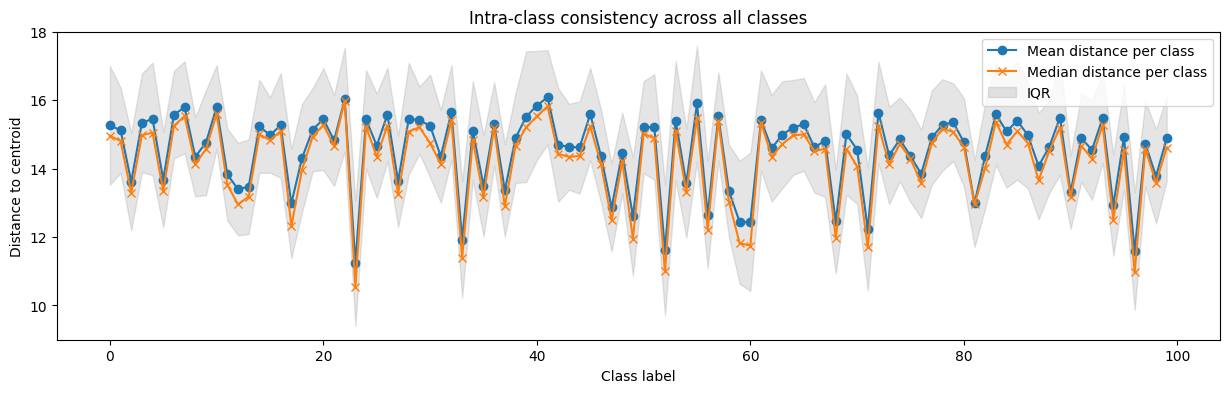

In [17]:
means = [class_stats[c]["mean"] for c in sorted(class_stats.keys())]
medians = [class_stats[c]["median"] for c in sorted(class_stats.keys())]
iqrs = [class_stats[c]["IQR"] for c in sorted(class_stats.keys())]

plt.figure(figsize=(15, 4))
plt.plot(means, label="Mean distance per class", marker='o')
plt.plot(medians, label="Median distance per class", marker='x')
plt.fill_between(range(len(means)), 
                 np.array(means)-np.array(iqrs)/2, 
                 np.array(means)+np.array(iqrs)/2, 
                 color='gray', alpha=0.2, label="IQR")
plt.xlabel("Class label")
plt.ylabel("Distance to centroid")
plt.title("Intra-class consistency across all classes")
plt.legend()
plt.show()

## Identify classes with a lot of outliers

In [18]:
outlier_thresholds = {}
outlier_counts = {}

for c in range(100):
    class_indices = (labels == c).nonzero(as_tuple=True)[0]
    if len(class_indices) == 0:
        continue

    class_distances = distances[class_indices].cpu().numpy()
    q75, q25 = np.percentile(class_distances, [75, 25])
    iqr = q75 - q25
    threshold = q75 + 1.5 * iqr  # outlier rule

    outlier_thresholds[c] = threshold
    outlier_counts[c] = np.sum(class_distances > threshold)

In [19]:
total_samples = len(train_set)

total_outliers = sum(outlier_counts.values())

dataset_noise_pct = (total_outliers / total_samples) * 100

print(f"Total samples: {total_samples}")
print(f"Total outliers (all classes): {total_outliers}")
print(f"Estimated noisy-label percentage (dataset-wide): "
      f"{dataset_noise_pct:.2f}%\n")

sorted_classes = sorted(outlier_counts.items(), key=lambda x: x[1], reverse=True)

print("Class-wise outlier statistics:")
for c, count in sorted_classes:
    class_size = (labels == c).sum().item()
    pct_of_class = (count / class_size) * 100 if class_size > 0 else 0
    pct_of_dataset = (count / total_samples) * 100

    print(
        f"Class {c:>3}: "
        f"{count:4d} outliers | "
        f"{pct_of_class:6.2f}% of class | "
        f"{pct_of_dataset:6.2f}% of dataset"
    )

Total samples: 50000
Total outliers (all classes): 858
Estimated noisy-label percentage (dataset-wide): 1.72%

Class-wise outlier statistics:
Class  37:   25 outliers |   3.73% of class |   0.05% of dataset
Class  33:   20 outliers |   2.73% of class |   0.04% of dataset
Class  48:   18 outliers |   3.54% of class |   0.04% of dataset
Class  30:   17 outliers |   2.73% of class |   0.03% of dataset
Class  23:   16 outliers |   2.15% of class |   0.03% of dataset
Class   1:   15 outliers |   2.45% of class |   0.03% of dataset
Class  17:   15 outliers |   2.91% of class |   0.03% of dataset
Class  11:   14 outliers |   2.72% of class |   0.03% of dataset
Class  46:   14 outliers |   1.62% of class |   0.03% of dataset
Class  47:   14 outliers |   5.09% of class |   0.03% of dataset
Class  94:   14 outliers |   3.05% of class |   0.03% of dataset
Class  68:   13 outliers |   2.60% of class |   0.03% of dataset
Class  73:   13 outliers |   2.59% of class |   0.03% of dataset
Class  76:   

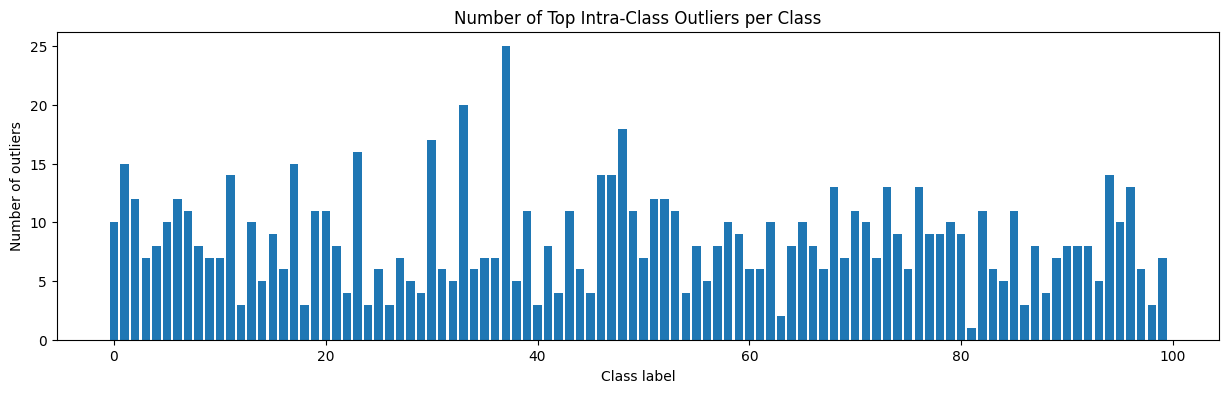

In [20]:
classes = list(outlier_counts.keys())
counts = [outlier_counts[c] for c in classes]

plt.figure(figsize=(15, 4))
plt.bar(classes, counts)
plt.xlabel("Class label")
plt.ylabel("Number of outliers")
plt.title("Number of Top Intra-Class Outliers per Class")
plt.show()

**Explanations**:
- low outlier rate which means that only extreme samples are detected;
- large gap compared to true noise (40%) which means most noisy labels are visually plausible;
- top outliers give us high-confidence mislabeled samples;
- using this we can still eliminate them and have a subset of samples that we know are mislabeled and can go through relabeling;
- the remaing samples are not entirely noise free;

# Inter-Class Overlap

In [21]:
print(f"Features shape: {features.shape}")
print(f"Centroids shape: {centroids.shape}")
print(f"Number of classes: {num_classes}")

Features shape: torch.Size([50000, 512])
Centroids shape: torch.Size([100, 512])
Number of classes: 100


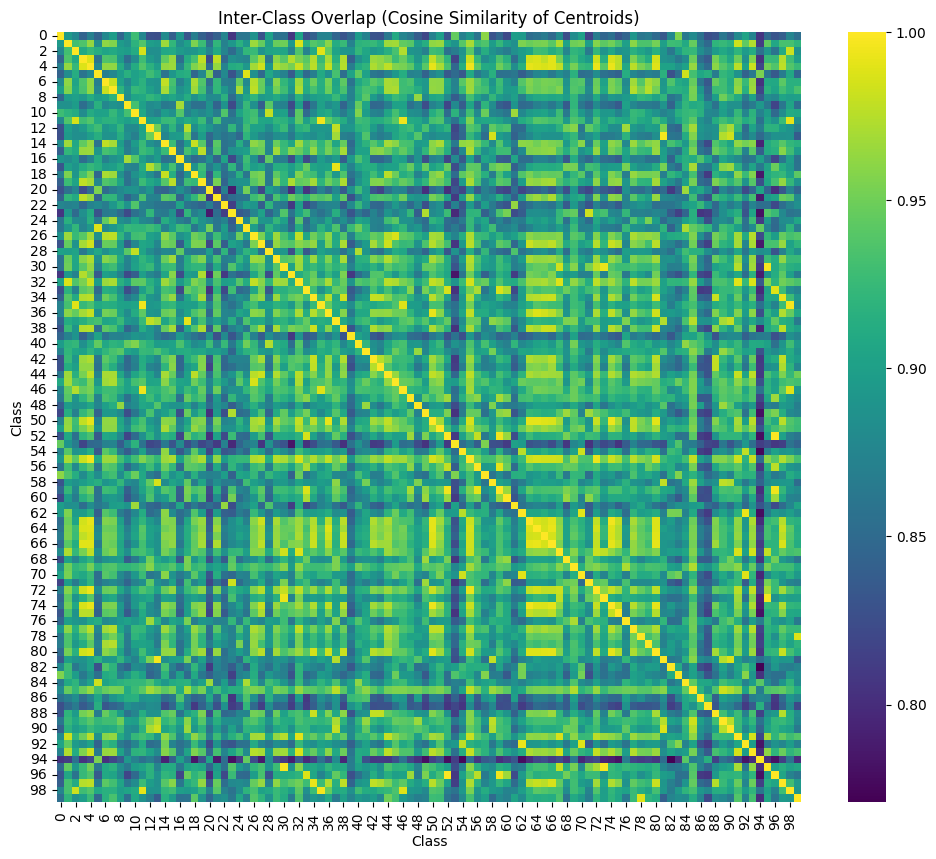

In [22]:
# Normalize centroids to unit vectors
centroids_norm = torch.nn.functional.normalize(centroids, dim=1)

# Cosine similarity matrix (100 x 100)
similarity_matrix = centroids_norm @ centroids_norm.T

# Convert to numpy for plotting
sim_matrix_np = similarity_matrix.numpy()

plt.figure(figsize=(12, 10))
sns.heatmap(sim_matrix_np, cmap="viridis", annot=False)
plt.title("Inter-Class Overlap (Cosine Similarity of Centroids)")
plt.xlabel("Class")
plt.ylabel("Class")
plt.show()

In [23]:
overlap_threshold = 0.8  
num_classes = centroids.size(0)

# Store per-class percentages
class_overlap_pct = []

# Count total overlapping samples
total_overlapping_samples = 0

for c in range(num_classes):
    class_indices = (labels == c).nonzero(as_tuple=True)[0]
    class_feats = features[class_indices]

    # Cosine similarity of each sample to all centroids
    class_feats_norm = torch.nn.functional.normalize(class_feats, dim=1)
    sims = class_feats_norm @ centroids_norm.T  # (num_samples_in_class, num_classes)

    # Ignore similarity to its own class
    sims[:, c] = -1

    # Count how many samples have similarity above threshold to *any other class*
    overlapping_mask = (sims > overlap_threshold).any(dim=1)
    num_overlapping = overlapping_mask.sum().item()
    total_overlapping_samples += num_overlapping

    pct = num_overlapping / len(class_indices) * 100
    class_overlap_pct.append(pct)

    print(f"Class {c}: {num_overlapping}/{len(class_indices)} samples overlapping "
          f"({pct:.2f}%)")

# Dataset-level overlap percentage
total_samples = len(features)
dataset_overlap_pct = total_overlapping_samples / total_samples * 100
print(f"\nTotal overlapping samples: {total_overlapping_samples}/{total_samples} "
      f"({dataset_overlap_pct:.2f}%)")

Class 0: 509/572 samples overlapping (88.99%)
Class 1: 573/611 samples overlapping (93.78%)
Class 2: 439/484 samples overlapping (90.70%)
Class 3: 667/681 samples overlapping (97.94%)
Class 4: 290/299 samples overlapping (96.99%)
Class 5: 468/472 samples overlapping (99.15%)
Class 6: 403/441 samples overlapping (91.38%)
Class 7: 523/599 samples overlapping (87.31%)
Class 8: 423/440 samples overlapping (96.14%)
Class 9: 471/564 samples overlapping (83.51%)
Class 10: 381/408 samples overlapping (93.38%)
Class 11: 497/514 samples overlapping (96.69%)
Class 12: 301/308 samples overlapping (97.73%)
Class 13: 539/544 samples overlapping (99.08%)
Class 14: 429/458 samples overlapping (93.67%)
Class 15: 411/413 samples overlapping (99.52%)
Class 16: 364/392 samples overlapping (92.86%)
Class 17: 506/515 samples overlapping (98.25%)
Class 18: 343/413 samples overlapping (83.05%)
Class 19: 494/508 samples overlapping (97.24%)
Class 20: 581/659 samples overlapping (88.16%)
Class 21: 562/572 sampl

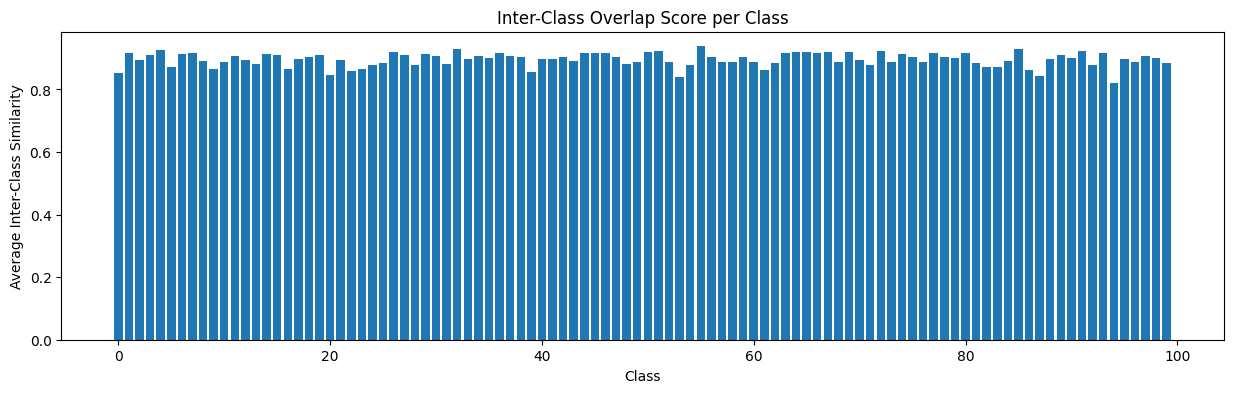

In [24]:
overlap_score = []

for c in range(num_classes):
    sims = similarity_matrix[c].clone()
    sims[c] = 0  # ignore self
    score = sims.mean().item()  # higher => more overlap
    overlap_score.append(score)

overlap_score = np.array(overlap_score)

# Plot per-class overlap
plt.figure(figsize=(15, 4))
plt.bar(range(num_classes), overlap_score)
plt.xlabel("Class")
plt.ylabel("Average Inter-Class Similarity")
plt.title("Inter-Class Overlap Score per Class")
plt.show()

## Correlate intra-class consistency with inter-class overlap

Correlation between centroid overlap and per-class overlapping samples: 0.409


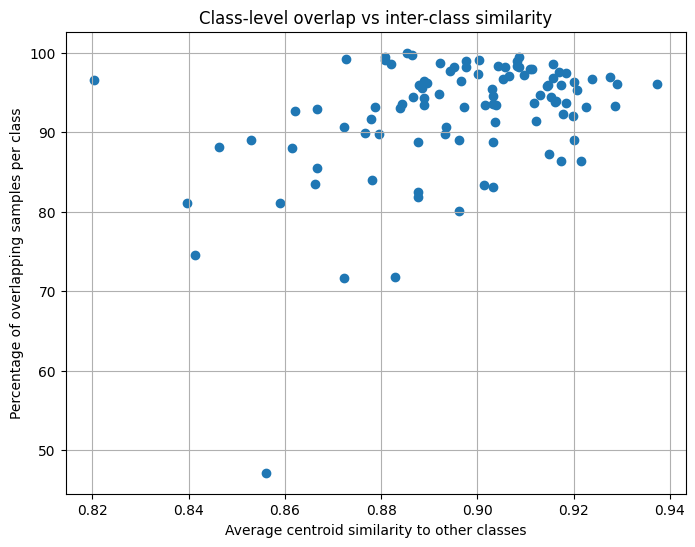

In [25]:
avg_centroid_overlap = []

for c in range(num_classes):
    sims = similarity_matrix[c].clone()
    sims[c] = 0  # ignore self
    avg_centroid_overlap.append(sims.mean().item())

avg_centroid_overlap = np.array(avg_centroid_overlap)

correlation = np.corrcoef(avg_centroid_overlap, class_overlap_pct)[0, 1]
print(f"Correlation between centroid overlap and per-class overlapping samples: {correlation:.3f}")

plt.figure(figsize=(8,6))
plt.scatter(avg_centroid_overlap, class_overlap_pct)
plt.xlabel("Average centroid similarity to other classes")
plt.ylabel("Percentage of overlapping samples per class")
plt.title("Class-level overlap vs inter-class similarity")
plt.grid(True)
plt.show()

**Explanations**:
- inter-class overlaping does not give enough information alone since most images are close;
- moderate correlation (0.41) indicates a relationship between class similarity and sample-level overlap;
- high overlapping percentages are largely due tio visually similar classes, not necessarily noise;

# General knowledge taken from intra-class consistency and inter-class overlap

1. Correlation:
    -  intra-class outliers (obvious mislabeled): 858 samples (1.7% dataset);
    -  inter-class overlapping samples (ambiguos/close to other class centroids): 46,176 samples;
    -  correlation between inter-class controid overlapp and per-class overlapping samples: 0.41;
    -  only a small fraction of true noisy labels are detected via intra-class consistency;
    -  overlap is partly expected due to class similarity, and partly could indifcate subtle labeling errors near class boundries;

Important: using raw pixels may overestimate overlap because low-level color/texture similarity dominates

# k-NN Label Agreement

In [26]:
features_np = features.cpu().numpy()
features_norm_np = F.normalize(torch.from_numpy(features_np), dim=1).numpy()
labels_np = labels.cpu().numpy()

K = 10  # Number of neighbors to check
knn = NearestNeighbors(n_neighbors=K + 1, algorithm='brute', metric='cosine')
knn.fit(features_norm_np)

distances_to_neighbors, neighbor_indices = knn.kneighbors(features_norm_np, n_neighbors=K + 1, return_distance=True)

agreement_scores = np.zeros(total_samples)

for i in tqdm(range(total_samples)):
    # Neighbors indices, excluding the first one 
    current_neighbors = neighbor_indices[i, 1:] 
    
    # Get the assigned labels of the neighbors
    neighbor_labels = labels_np[current_neighbors]
    
    # Check how many neighbors match the sample's assigned label
    current_label = labels_np[i]
    agreement_count = np.sum(neighbor_labels == current_label)
    
    # Store the agreement score (as a percentage of K)
    agreement_scores[i] = agreement_count / K

# Combine the results into a DataFrame for easy analysis
df_analysis = pd.DataFrame({\
    'label': labels_np,\
    'agreement_score': agreement_scores,\
    'distance_to_centroid': all_distances\
})

print(f"k-NN Agreement Score (K={K}) statistics:")
print(df_analysis['agreement_score'].describe())

# Thresholds for separating clean and noisy data
# Samples with near-perfect agreement 90% or higher)
clean_threshold = 0.9
clean_set_indices = df_analysis[df_analysis['agreement_score'] >= clean_threshold].index.values
clean_set_size = len(clean_set_indices)
clean_set_pct = clean_set_size / total_samples * 100

print(f"\nClean Set (Agreement >= {clean_threshold}):")
print(f"  Size: {clean_set_size} samples ({clean_set_pct:.2f}% of dataset)")

# POTENTIAL NOISY SET (for relabeling): Samples with low agreement
target_noisy_size = int(total_samples * 0.40) 
low_agreement_threshold = df_analysis['agreement_score'].quantile(1.0 - target_noisy_size / total_samples) 
noisy_set_indices = df_analysis[df_analysis['agreement_score'] <= low_agreement_threshold].index.values
noisy_set_size = len(noisy_set_indices)

print(f"\nPotential Noisy Set (Targeting ~{target_noisy_size} samples or 40%):")
print(f"  Agreement score threshold: <= {low_agreement_threshold:.3f}")
print(f"  Size: {noisy_set_size} samples ({(noisy_set_size / total_samples) * 100:.2f}% of dataset)")

# Final check on the identified clean set
clean_set_avg_agreement = df_analysis.loc[clean_set_indices, 'agreement_score'].mean()
print(f"\nAverage agreement in the 'Clean' subset: {clean_set_avg_agreement:.3f}")

100%|██████████| 50000/50000 [00:00<00:00, 169186.83it/s]


k-NN Agreement Score (K=10) statistics:
count    50000.000000
mean         0.300772
std          0.310623
min          0.000000
25%          0.000000
50%          0.200000
75%          0.500000
max          1.000000
Name: agreement_score, dtype: float64

Clean Set (Agreement >= 0.9):
  Size: 4073 samples (8.15% of dataset)

Potential Noisy Set (Targeting ~20000 samples or 40%):
  Agreement score threshold: <= 0.300
  Size: 31845 samples (63.69% of dataset)

Average agreement in the 'Clean' subset: 0.945


In [27]:
HIGH_AGREEMENT_THRESHOLD = 0.9
MEDIUM_AGREEMENT_THRESHOLD = 0.75
NOISY_THRESHOLD = 0.3 

medium_agreement_set = df_analysis[
    (df_analysis['agreement_score'] >= MEDIUM_AGREEMENT_THRESHOLD) & 
    (df_analysis['agreement_score'] < HIGH_AGREEMENT_THRESHOLD)
]
medium_size = len(medium_agreement_set)
medium_pct = (medium_size / total_samples) * 100

print(f"--- Additional Subset Analysis ---")
print(f"Medium Agreement Set (0.75 <= Agreement < 0.90):")
print(f"  Size: {medium_size} samples ({medium_pct:.2f}% of dataset)")

unknown_agreement_set = df_analysis[
    (df_analysis['agreement_score'] > NOISY_THRESHOLD) & 
    (df_analysis['agreement_score'] < MEDIUM_AGREEMENT_THRESHOLD)
]
unknown_size = len(unknown_agreement_set)
unknown_pct = (unknown_size / total_samples) * 100

print(f"\nUnknown Set (0.30 < Agreement < 0.75):")
print(f"  Size: {unknown_size} samples ({unknown_pct:.2f}% of dataset)")

clean_size = len(df_analysis[df_analysis['agreement_score'] >= HIGH_AGREEMENT_THRESHOLD]) # >= 0.9
noisy_size = len(df_analysis[df_analysis['agreement_score'] <= NOISY_THRESHOLD]) # <= 0.3
total_checked = clean_size + medium_size + unknown_size + (total_samples - clean_size - medium_size - unknown_size - noisy_size)


total_accounted = clean_size + medium_size + unknown_size

print(f"\nTotal samples accounted for (Clean + Medium + Unknown): {total_accounted}")
print(f"Total samples in the high-confidence noisy set (<= 0.30): {noisy_size}")

--- Additional Subset Analysis ---
Medium Agreement Set (0.75 <= Agreement < 0.90):
  Size: 2424 samples (4.85% of dataset)

Unknown Set (0.30 < Agreement < 0.75):
  Size: 11658 samples (23.32% of dataset)

Total samples accounted for (Clean + Medium + Unknown): 18155
Total samples in the high-confidence noisy set (<= 0.30): 31845


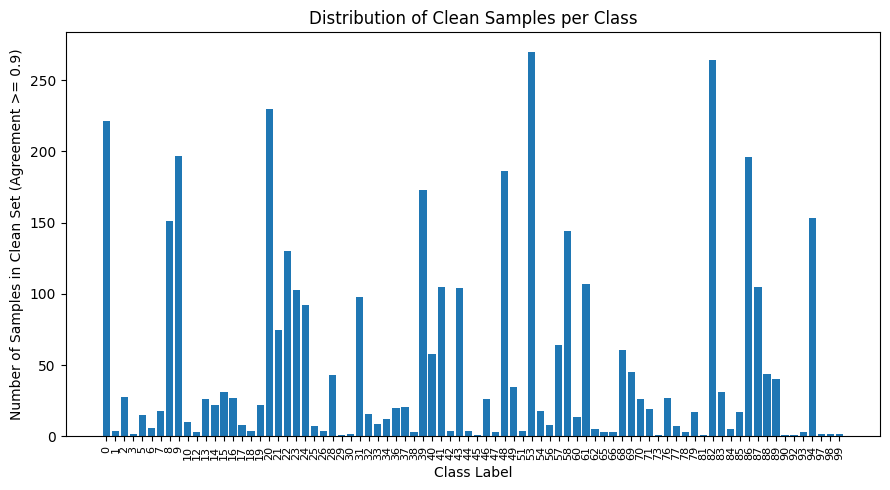

In [28]:
clean_threshold = 0.9

clean_set = df_analysis[df_analysis['agreement_score'] >= clean_threshold]

clean_set_counts = Counter(clean_set['label'])

labels_sorted = sorted(clean_set_counts.keys())
counts_sorted = [clean_set_counts[l] for l in labels_sorted]

x_labels = [str(l) for l in labels_sorted]

plt.figure(figsize=(9, 5))
plt.bar(x_labels, counts_sorted, width=0.8)

plt.xlabel("Class Label")
plt.ylabel(f"Number of Samples in Clean Set (Agreement >= {clean_threshold})")
plt.title("Distribution of Clean Samples per Class")

plt.xticks(rotation=90, fontsize=8) 
plt.tight_layout()

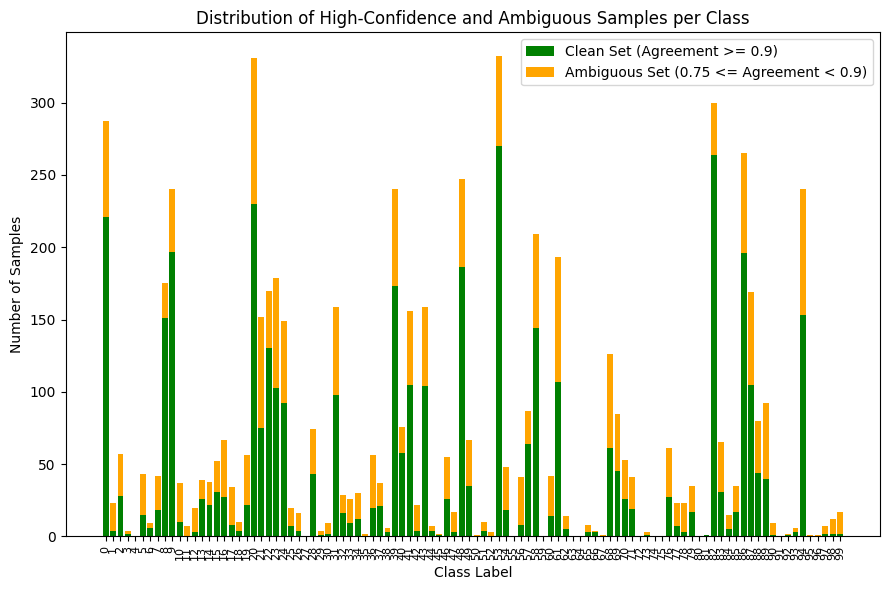

In [29]:
high_agreement_threshold = 0.9
medium_agreement_threshold = 0.75

clean_set = df_analysis[df_analysis['agreement_score'] >= high_agreement_threshold]

ambiguous_set = df_analysis[
    (df_analysis['agreement_score'] >= medium_agreement_threshold) &
    (df_analysis['agreement_score'] < high_agreement_threshold)
]

clean_counts = Counter(clean_set['label'])
ambiguous_counts = Counter(ambiguous_set['label'])

all_classes = range(100)
clean_counts_sorted = [clean_counts.get(c, 0) for c in all_classes]
ambiguous_counts_sorted = [ambiguous_counts.get(c, 0) for c in all_classes]

x_labels = [str(l) for l in all_classes]

plt.figure(figsize=(9, 6))

plt.bar(
    x_labels, 
    clean_counts_sorted, 
    width=0.8, 
    color='green', 
    label=f'Clean Set (Agreement >= {high_agreement_threshold})'
)

plt.bar(
    x_labels, 
    ambiguous_counts_sorted, 
    width=0.8, 
    bottom=clean_counts_sorted, 
    color='orange', 
    label=f'Ambiguous Set ({medium_agreement_threshold} <= Agreement < {high_agreement_threshold})'
)

plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.title("Distribution of High-Confidence and Ambiguous Samples per Class")
plt.legend()

plt.xticks(rotation=90, fontsize=8) 
plt.tight_layout()

In [30]:
CLEAN_AGREEMENT_THRESHOLD = 0.9
LOW_SAMPLE_THRESHOLD = 40
TOP_K_OVERLAPS = 5
all_classes = range(num_classes)

clean_set = df_analysis[df_analysis['agreement_score'] >= CLEAN_AGREEMENT_THRESHOLD]

clean_counts_per_class = Counter(clean_set['label'])

low_sample_classes = []
low_sample_counts = {}

for c in all_classes:
    count = clean_counts_per_class.get(c, 0)
    if count < LOW_SAMPLE_THRESHOLD and count > 0:
        low_sample_classes.append(c)
        low_sample_counts[c] = count

overlap_results = []
for target_class in low_sample_classes:
    sims = sim_matrix_np[target_class].copy() 
    
    sims[target_class] = -1.0 
    
    top_indices = np.argsort(sims)[::-1][:TOP_K_OVERLAPS]
    
    overlap_info = []
    for i in range(TOP_K_OVERLAPS):
        overlap_class = top_indices[i]
        overlap_score = sims[overlap_class]
        overlap_info.append((overlap_class, overlap_score))
    
    overlap_results.append({
        'class': target_class,
        'clean_count': low_sample_counts[target_class],
        'overlaps': overlap_info
    })


print(f"Total number of classes with fewer than {LOW_SAMPLE_THRESHOLD} clean samples: {len(low_sample_classes)}\n")

print("--- Inter-Class Overlap for Low-Sample Clean Classes ---")
for result in overlap_results:
    print(f"Class {result['class']:<3} (Clean Samples: {result['clean_count']}):")
    print(f"  Top {TOP_K_OVERLAPS} Overlapping Classes (Centroid Cosine Similarity):")
    for overlap_class, score in result['overlaps']:
        print(f"    Class {overlap_class:<3}: {score:.4f}")
    print("-" * 30)

Total number of classes with fewer than 40 clean samples: 55

--- Inter-Class Overlap for Low-Sample Clean Classes ---
Class 1   (Clean Samples: 4):
  Top 5 Overlapping Classes (Centroid Cosine Similarity):
    Class 32 : 0.9874
    Class 91 : 0.9821
    Class 93 : 0.9731
    Class 67 : 0.9716
    Class 55 : 0.9699
------------------------------
Class 2   (Clean Samples: 28):
  Top 5 Overlapping Classes (Centroid Cosine Similarity):
    Class 35 : 0.9885
    Class 11 : 0.9855
    Class 98 : 0.9817
    Class 46 : 0.9727
    Class 36 : 0.9454
------------------------------
Class 3   (Clean Samples: 2):
  Top 5 Overlapping Classes (Centroid Cosine Similarity):
    Class 66 : 0.9894
    Class 4  : 0.9879
    Class 64 : 0.9870
    Class 74 : 0.9857
    Class 63 : 0.9842
------------------------------
Class 5   (Clean Samples: 15):
  Top 5 Overlapping Classes (Centroid Cosine Similarity):
    Class 25 : 0.9881
    Class 84 : 0.9824
    Class 20 : 0.9547
    Class 94 : 0.9538
    Class 40 : 0

**Explanations**:
- k-NN identifies a subset where the images have the correct labels;
- however, this subset is extremly inbalanced which means that some classes will need additional points added to them;
- adding medium agreement samples does not improve the class balance at all;
- identifying which classes have a small amount of samples is crucials since it allows us to expand them to create a stable set;

# Proposed algorithm

1. Identify the intra-class outliers and remove them from the dataset (they will be relabeled later)
2. Use 10-NN (check the really close ones) to identify the stable set
3. Try to balance the set focusing on the classes with below mean clean sample:
    1. Check with what classes to they overlap
    2. Try a higher K value for k-NN in order to redistribute the some samples
    3. Only look at  the medium agreement set (above 75%) in regard with overlaping (if not enough, carefully look over the dominant classes in the stable set - dominant means a lot of samples)
    4. Attempt to get the classes at least above 20 or at least closer to the mean
4. Relabel the mislabeled set


**Training:**
1. Train on the stable set at first since we somewhat know that we can trust those labels (other noise-dealing techniques should not be removed)
2. Train on the relabaled set